# The notebook for training the text to image model

## Package Preparation

### Import packages

In [1]:
!pip install -q datasets
!pip install -q transformers
!pip install -q accelerate
!pip install -q git+https://github.com/huggingface/diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies .

In [2]:
import logging
import math
import os
import random
import glob
from pathlib import Path

import datasets
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

### Check diffuser version & Save model card

In [3]:
check_min_version("0.16.0.dev0")

logger = get_logger(__name__, log_level="INFO")

In [4]:
def save_model_card(repo_id: str, images=None, base_model=str, dataset_name=str, repo_folder=None):
    img_str = ""
    for i, image in enumerate(images):
        image.save(os.path.join(repo_folder, f"image_{i}.png"))
        img_str += f"![img_{i}](./image_{i}.png)\n"

    yaml = f"""
---
license: creativeml-openrail-m
base_model: {base_model}
tags:
- stable-diffusion
- stable-diffusion-diffusers
- text-to-image
- diffusers
- lora
inference: true
---
    """
    model_card = f"""
# LoRA text2image fine-tuning - {repo_id}
These are LoRA adaption weights for {base_model}. The weights were fine-tuned on the {dataset_name} dataset. You can find some example images in the following. \n
{img_str}
"""
    with open(os.path.join(repo_folder, "README.md"), "w") as f:
        f.write(yaml + model_card)

## Set Basic Arguments

### Saving Directory

In [5]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter the directory name to save model at.

output_dir = "ml_stable_diffusion_weights/lora" #@param {type:"string"}
if save_to_gdrive:
    output_dir = "/content/drive/MyDrive/" + output_dir
else:
    output_dir = "/content/" + output_dir

print(f"[*] Weights will be saved at {output_dir}")

!mkdir -p $output_dir

[*] Weights will be saved at /content/ml_stable_diffusion_weights/lora


### Configure Accelerator

In [6]:
logging_dir = os.path.join(output_dir, "logs")
accelerator_project_config = ProjectConfiguration(total_limit=None)

accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision="fp16",
        log_with="tensorboard",
        logging_dir=logging_dir,
        project_config=accelerator_project_config,
    )

/usr/local/lib/python3.9/dist-packages/accelerate/accelerator.py:249: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(


### Handle Repository Creation

In [7]:
if accelerator.is_main_process:
        if output_dir is not None:
            os.makedirs(output_dir, exist_ok=True)

### Load scheduler, tokenizer, models

In [8]:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer", revision=None
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=None
)
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=None)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", revision=None
)
# freeze parameters of models to save more memory
unet.requires_grad_(False)
vae.requires_grad_(False)

text_encoder.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [9]:
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

### Move unet, vae, text_encoder to device

In [10]:
print(accelerator.device)

cuda


In [11]:
unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)
text_encoder.to(accelerator.device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

## Start adding LoRA weights to attention layers

    # It's important to realize here how many attention weights will be added and of which sizes
    # The sizes of the attention layers consist only of two different variables:
    # 1) - the "hidden_size", which is increased according to `unet.config.block_out_channels`.
    # 2) - the "cross attention size", which is set to `unet.config.cross_attention_dim`.

    # Let's first see how many attention processors we will have to set.
    # For Stable Diffusion, it should be equal to:
    # - down blocks (2x attention layers) * (2x transformer layers) * (3x down blocks) = 12
    # - mid blocks (2x attention layers) * (1x transformer layers) * (1x mid blocks) = 2
    # - up blocks (2x attention layers) * (3x transformer layers) * (3x down blocks) = 18
    # => 32 layers

### Set correct lora layers

In [12]:
lora_attn_procs = {}
for name in unet.attn_processors.keys():
  cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
  # print(name)
  if name.startswith("mid_block"):
    # print(unet.config.block_out_channels)
    hidden_size = unet.config.block_out_channels[-1]
  elif name.startswith("up_blocks"):
    block_id = int(name[len("up_blocks.")])
    hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    # print(hidden_size)
  elif name.startswith("down_blocks"):
    block_id = int(name[len("down_blocks.")])
    hidden_size = unet.config.block_out_channels[block_id]
    # print(hidden_size)

  lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)

unet.set_attn_processor(lora_attn_procs)
lora_layers = AttnProcsLayers(unet.attn_processors)


### Initalize optimizers

In [13]:
#@markdown Parameters for adamW

optimizer_cls = torch.optim.AdamW
learning_rate = 1e-4 #@param {type:"number"}
adam_beta1 = 0.9 #@param {type:"number"}
adam_beta2 = 0.999 #@param {type:"number"}
adam_weight_decay = 1e-2 #@param {type:"number"}
adam_epsilon = 1e-08 #@param {type:"number"}

In [14]:
optimizer = optimizer_cls(
    lora_layers.parameters(),
    lr=learning_rate,
    betas=(adam_beta1,adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

### Load Quickdraw Dataset

Read the class name

In [15]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2023-04-27 15:58:36--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2023-04-27 15:58:36 (42.4 MB/s) - ‘mini_classes.txt’ saved [760/760]



In [16]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [17]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

Download Data

In [18]:
!mkdir data

In [19]:
import urllib.request
from tqdm.auto import tqdm
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in tqdm(classes):        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        # print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [20]:
download()

  0%|          | 0/100 [00:00<?, ?it/s]

load the data

In [21]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [22]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [23]:
print(len(x_train))

320000


hot_dog


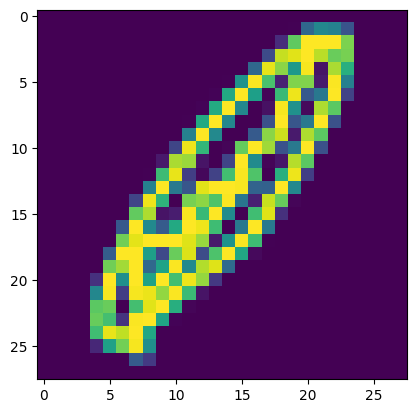

In [24]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [25]:
print(len(classes))
df_x_train = pd.DataFrame(x_train, columns=class_names)

100


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:722 in __init__                      │
│                                                                                                  │
│     719 │   │   │   │   │   typ=manager,                                                         │
│     720 │   │   │   │   )                                                                        │
│     721 │   │   │   else:                                                                        │
│ ❱   722 │   │   │   │   mgr = ndarray_to_mgr(                                                    │
│     723 │   │   │   │   │   data,                                                                │
│     724 │   │   │   │   │   index,                                                               │
│     725 │   │   │   │   │   columns,                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:349 in              │
│ ndarray_to_mgr                                                                                   │
│                                                                                                  │
│    346 │   │   values.shape[0], values.shape[1], index=index, columns=columns                    │
│    347 │   )                                                                                     │
│    348 │                                                                                         │
│ ❱  349 │   _check_values_indices_shape_match(values, index, columns)                             │
│    350 │                                                                                         │
│    351 │   if typ == "array":                                                                    │
│    352                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:420 in              │
│ _check_values_indices_shape_match                                                                │
│                                                                                                  │
│    417 │   │                                                                                     │
│    418 │   │   passed = values.shape                                                             │
│    419 │   │   implied = (len(index), len(columns))                                              │
│ ❱  420 │   │   raise ValueError(f"Shape of passed values is {passed}, indices imply {implied}")  │
│    421                                                                                           │
│    422                                                                                           │
│    423 def dict_to_mgr(                                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Shape of passed values is (320000, 784), indices imply (320000, 100)